<a href="https://colab.research.google.com/github/FiLM2072/Arduino-Nano33-BLE-Sense-assignment/blob/main/train_sine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** Import Library ที่จำเป็น **

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

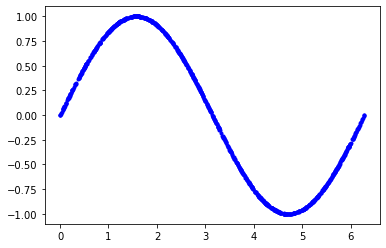

In [ ]:

SAMPLES = 1024

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*3.14159265359, size=SAMPLES).astype(np.float32)

np.random.shuffle(x_values)

y_values = np.sin(x_values).astype(np.float32)

plt.plot(x_values, y_values, 'b.')
plt.show()

In [ ]:

TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

X_train, X_test, X_val = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_val = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

print(f'#traning = {X_train.shape[0]}')
print(f'#validation = {X_val.shape[0]}')
print(f'#test = {X_test.shape[0]}')

#traning = 614
#validation = 206
#test = 204


In [ ]:
model = tf.keras.Sequential()

model.add(keras.layers.Dense(4, activation='relu', input_shape=(1,)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(4, activation='relu'))

model.add(keras.layers.Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [ ]:
history = model.fit(X_train,y_train,epochs=500 ,batch_size=64,validation_data=(X_val,y_val))

Epoch 1/500
10/10 [==============================] - 1s 23ms/step - loss: 0.6136 - mae: 0.6136 - val_loss: 0.5781 - val_mae: 0.5781
Epoch 2/500
10/10 [==============================] - 0s 3ms/step - loss: 0.5998 - mae: 0.5998 - val_loss: 0.5647 - val_mae: 0.5647
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5822 - mae: 0.5822 - val_loss: 0.5477 - val_mae: 0.5477
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.5582 - mae: 0.5582 - val_loss: 0.5277 - val_mae: 0.5277
Epoch 5/500
10/10 [==============================] - 0s 4ms/step - loss: 0.5370 - mae: 0.5370 - val_loss: 0.5128 - val_mae: 0.5128
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5159 - mae: 0.5159 - val_loss: 0.4951 - val_mae: 0.4951
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4916 - mae: 0.4916 - val_loss: 0.4778 - val_mae: 0.4778
Epoch 8/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4706 - 

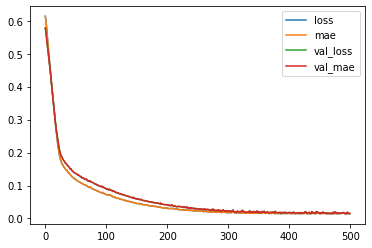

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot();

7/7 [==============================] - 0s 2ms/step - loss: 0.0153 - mae: 0.0153


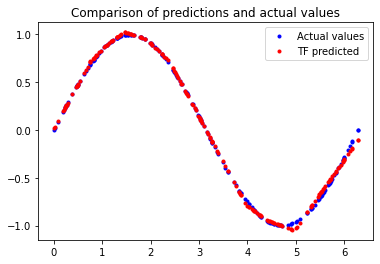

In [ ]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(X_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(X_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(X_test, y_test, 'b.', label='Actual values')
plt.plot(X_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

In [ ]:
# สร้าง header file 
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

# Convert Keras model to a tflite model
## แบบ DEFAULT

In [ ]:

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open('sine_model' + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp_x5l6mnf/assets


2736

In [ ]:
# Write TFLite model to a C source (or header) file
with open('sine_model' + '.h', 'w') as file:
  file.write(hex_to_c_array(model_tflite, 'sine_model'))

## Quantization

In [ ]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([X_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open('sine_model_quantize.tflite', "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpfs8f156x/assets


INFO:tensorflow:Assets written to: /tmp/tmpfs8f156x/assets


2648

In [ ]:
# Write TFLite model to a C source (or header) file
with open('sine_model_quantize' + '.h', 'w') as file:
  file.write(hex_to_c_array(model_tflite, 'sine_model_quantize'))